In [1]:
pip install numpy matplotlib pandas tensorflow seaborn

You should consider upgrading via the 'c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install scikit-learn

You should consider upgrading via the 'c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
import seaborn as sns
import matplotlib.gridspec as gridspec

In [4]:
from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

In [5]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

In [6]:
# Importing benign gafgyt combo dataset for a given device id (1-9)
def import_dataset_benign_gagfyt_combo(device_id):
    # Data normal
    normal = pd.read_csv('{}.benign.csv'.format(device_id))
    n_X = normal.iloc[:,] 
    n_X_scaled = MinMaxScaler().fit_transform(n_X.values) #scale n_X thành dãy 0-1 r lưu vô n_X_scaled
    n_y = np.ones(n_X.shape[0]) # 1 represents normal
    # Data anomalous
    anomalous = pd.read_csv('{}.gafgyt.combo.csv'.format(device_id))
    a_X = anomalous.iloc[:,]
    a_X_scaled = MinMaxScaler().fit_transform(a_X.values) #scale a_X thành dãy 0-1 r lưu vô a_X_scaled
    a_y = np.zeros(a_X.shape[0]) # 0 represents anomalous

    #normal.info()
    #normal.describe()
    #normal.head()

    #anomalous.info()
    #anomalous.describe()
    #anomalous.head()

    return (n_X_scaled, n_y, a_X_scaled, a_y)

In [7]:

def generate_and_train_autoencoder(X):
    ## input layer
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
        # Tạo lớp encoded với 100 units + hàm ac_re kiểm soát overfitting + hàm kích hoạt tanh
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
        # Tiếp tục với 50 units + hàm kích hoạt relu
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
        # Bắt đầu quá trình decoding từ encoding trở lại không gian ban đầu với 50 units và hàm kích hoạt là 'tanh'.
    decoded = Dense(50, activation='tanh')(encoded)
        #Tiếp tục quá trình decoding với 100 units và hàm kích hoạt 'tanh'.
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer - Lớp đầu ra
    
    output_layer = Dense(X.shape[1], activation='relu')(decoded) # Số units = só futures input data
    # Tạo một mô hình autoencoder từ input_layer và output_layer
    autoencoder = Model(input_layer, output_layer)
    # Compile model 
    autoencoder.compile(optimizer="adadelta", loss="mse")

    
    # Bắt đầu train model
    autoencoder.fit(X[0:1000], X[0:1000],
                    batch_size = 256, epochs = 10,
                    shuffle = True, validation_split = 0.20);

    return autoencoder

In [8]:
# hidden representation
def get_hidden_representation_normal_anomalous(autoencoder, n_X, a_X):
    # Create neural network model
    hidden_representation = Sequential()
    # Add layer
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    # Tính 3000 data normail
    normal_hid_rep = hidden_representation.predict(n_X[:3000])
    # Tính 3000 data anomolous
    anomalous_hid_rep = hidden_representation.predict(a_X[:3000])

    return (normal_hid_rep, anomalous_hid_rep)

In [9]:
def tsne_plot(x, y, title="Scatter Plot", name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x) # Dùng tsne để giảm chiều còn 2 rồi lưu vào X_t

    plt.figure(figsize=(12, 8)) # Tạo figure với 12x8 inch
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Anomalous')

    plt.title(title)
    plt.legend(loc='best');
    plt.savefig('{}-{}'.format(title,name));
    plt.show();

In [10]:
# Combine normal and anomalous data
def combine_normal_anomalous(normal, anomalous):
    X = np.append(normal, anomalous, axis = 0)  # Ghép 2 data lại với nhau tạo thành X
    y_n = np.ones(normal.shape[0]) # Tạo array y_n chứa giá trị 1
    y_a = np.zeros(anomalous.shape[0]) # Tạo array y_a chứa giá trị 0
    y = np.append(y_n, y_a) # Ghép mảng lại thành y

    return (X, y)

In [11]:
def show_confusion_matrix(test, pred):
  conf_matrix = confusion_matrix(test, pred)
  # Dùng seaborn vẽ heatmap
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['Nomal', 'Anomalous'],
              yticklabels=['Nomal', 'Anomalous'])
  # Đặt nhãn cho x, y
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [12]:
# Evaluate model's performace - Đánh giá hiệu suất model
def evaluate_model(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
    clf = LogisticRegression(solver="lbfgs").fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    return (test_y, pred_y)

In [13]:
# Show model's report - Trực quan hidden representation
def show_model_report(title, X, y, hid_X, hid_y, test_y, pred_y):
    #tsne_plot(X, y, '{}-original'.format(title), "original.png")
    tsne_plot(hid_X, hid_y, title, "hidden_representation.png")

    print(title)
    print ("")
    print ("Classification Report: ")
    print (classification_report(test_y, pred_y))

    print ("")
    print ("Accuracy Score: ", accuracy_score(test_y, pred_y))

In [14]:
# Detect zero-day attack
def detect_zero_day_attack(device_name, device_id):
    (n_X_scaled, n_y, a_X_scaled, a_y) = import_dataset_benign_gagfyt_combo(device_id)
    # Dùng data normal train encoder model
    autoencoder = generate_and_train_autoencoder(n_X_scaled)
    #Tính toán hidden representation từ mô hình autoencoder
    (normal_hid_rep, anomalous_hid_rep) = get_hidden_representation_normal_anomalous(autoencoder, n_X_scaled, a_X_scaled)
    # Gom 2 data lại
    (X, y) = combine_normal_anomalous(n_X_scaled, a_X_scaled)
    (hid_X, hid_y) = combine_normal_anomalous(normal_hid_rep, anomalous_hid_rep)
    (test_y, pred_y) = evaluate_model(hid_X, hid_y) # Train model Logistic Regression

    show_model_report(device_name, X, y, hid_X, hid_y, test_y, pred_y)
    show_confusion_matrix(test_y, pred_y)




Epoch 1/10

4/4 [==============================] - 17s 936ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 2/10
4/4 [==============================] - 1s 187ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 3/10
4/4 [==============================] - 1s 214ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 4/10
4/4 [==============================] - 1s 191ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 5/10
4/4 [==============================] - 1s 179ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 6/10
4/4 [==============================] - 1s 177ms/step - loss: 0.0403 - val_loss: 0.0375
Epoch 7/10
4/4 [==============================] - 1s 184ms/step - loss: 0.0403 - val_loss: 0.0375
Epoch 8/10
4/4 [==============================] - 1s 179ms/step - loss: 0.0402 - val_loss: 0.0375
Epoch 9/10
4/4 [==============================] - 1s 192ms/step - loss: 0.0402 - val_loss: 0.0375
Epoch 10/10
94/94 [==============================] - 2s 20ms/step


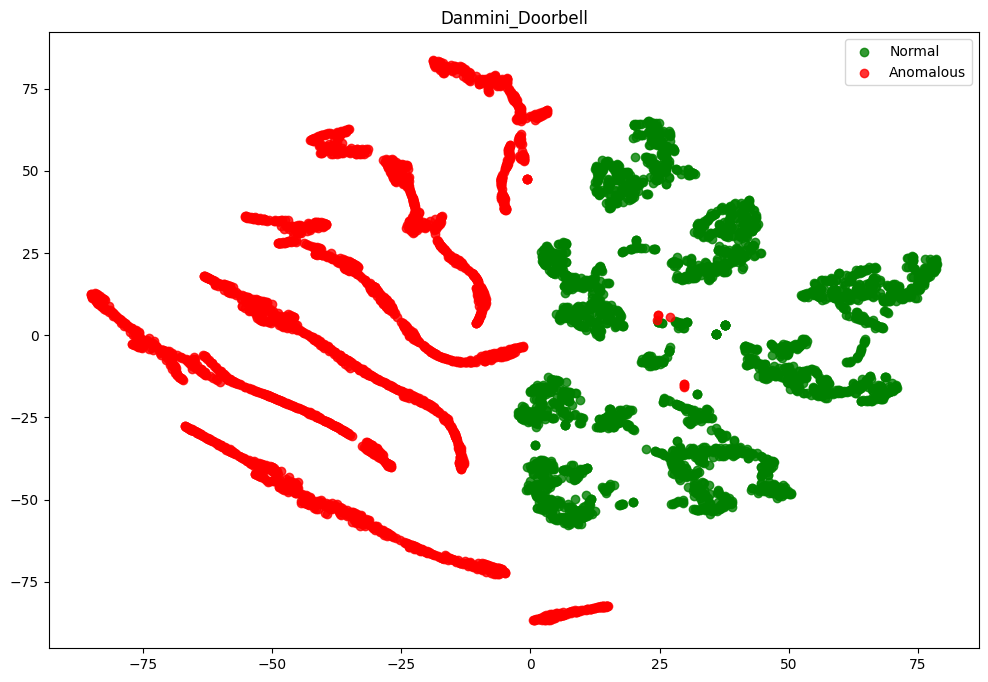

Danmini_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       715
         1.0       1.00      1.00      1.00       785

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


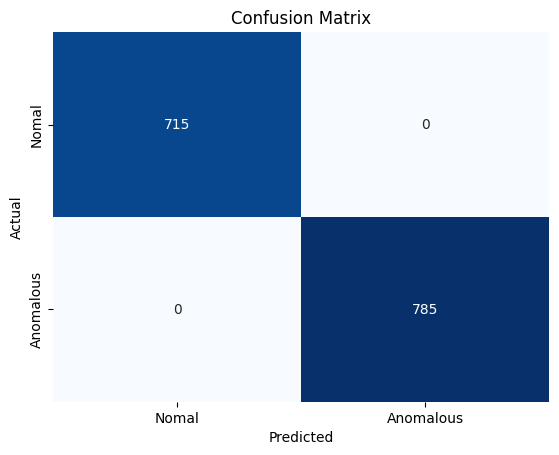

Epoch 1/10
4/4 [==============================] - 3s 235ms/step - loss: 0.0850 - val_loss: 0.0775
Epoch 2/10
4/4 [==============================] - 0s 49ms/step - loss: 0.0850 - val_loss: 0.0775
Epoch 3/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0849 - val_loss: 0.0775
Epoch 4/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0849 - val_loss: 0.0775
Epoch 5/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0849 - val_loss: 0.0774
Epoch 6/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0849 - val_loss: 0.0774
Epoch 7/10
4/4 [==============================] - 0s 51ms/step - loss: 0.0848 - val_loss: 0.0774
Epoch 8/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0848 - val_loss: 0.0774
Epoch 9/10
4/4 [==============================] - 0s 45ms/step - loss: 0.0848 - val_loss: 0.0774
Epoch 10/10
94/94 [==============================] - 0s 3ms/step


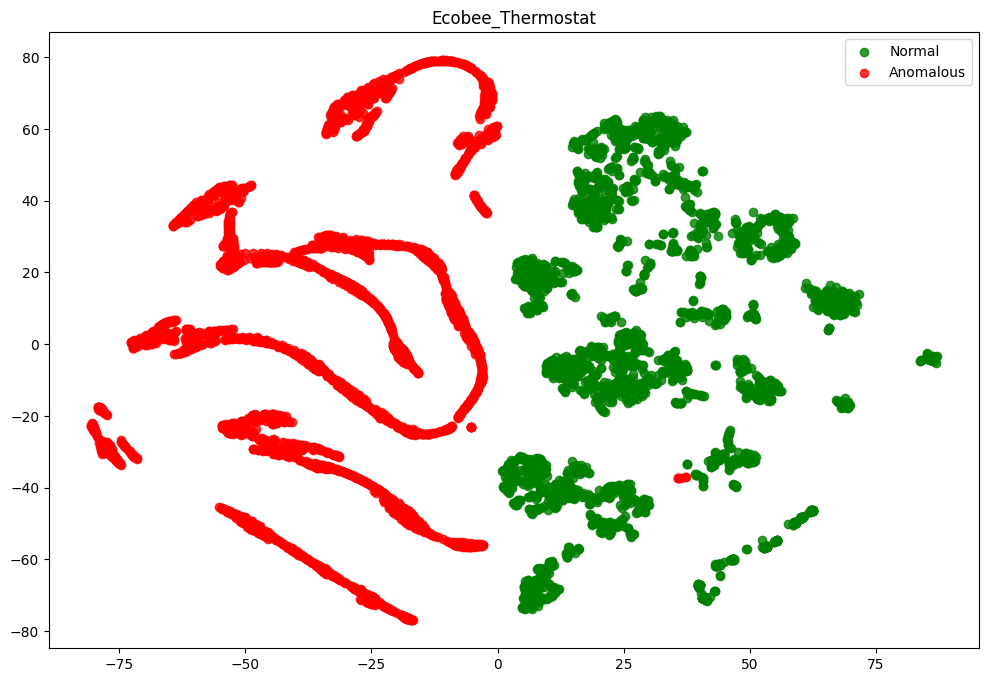

Ecobee_Thermostat

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       772
         1.0       1.00      1.00      1.00       728

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.998


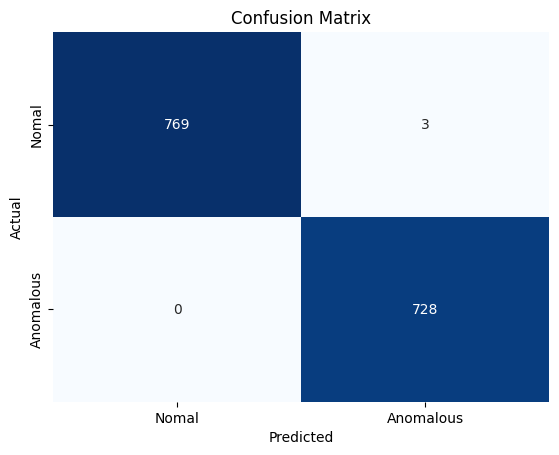

Epoch 1/10
4/4 [==============================] - 3s 202ms/step - loss: 0.0992 - val_loss: 0.0960
Epoch 2/10
4/4 [==============================] - 0s 50ms/step - loss: 0.0992 - val_loss: 0.0960
Epoch 3/10
4/4 [==============================] - 0s 56ms/step - loss: 0.0991 - val_loss: 0.0960
Epoch 4/10
4/4 [==============================] - 0s 48ms/step - loss: 0.0991 - val_loss: 0.0959
Epoch 5/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0991 - val_loss: 0.0959
Epoch 6/10
4/4 [==============================] - 0s 50ms/step - loss: 0.0991 - val_loss: 0.0959
Epoch 7/10
4/4 [==============================] - 0s 45ms/step - loss: 0.0990 - val_loss: 0.0959
Epoch 8/10
4/4 [==============================] - 0s 40ms/step - loss: 0.0990 - val_loss: 0.0958
Epoch 9/10
4/4 [==============================] - 0s 53ms/step - loss: 0.0990 - val_loss: 0.0958
Epoch 10/10
94/94 [==============================] - 1s 5ms/step


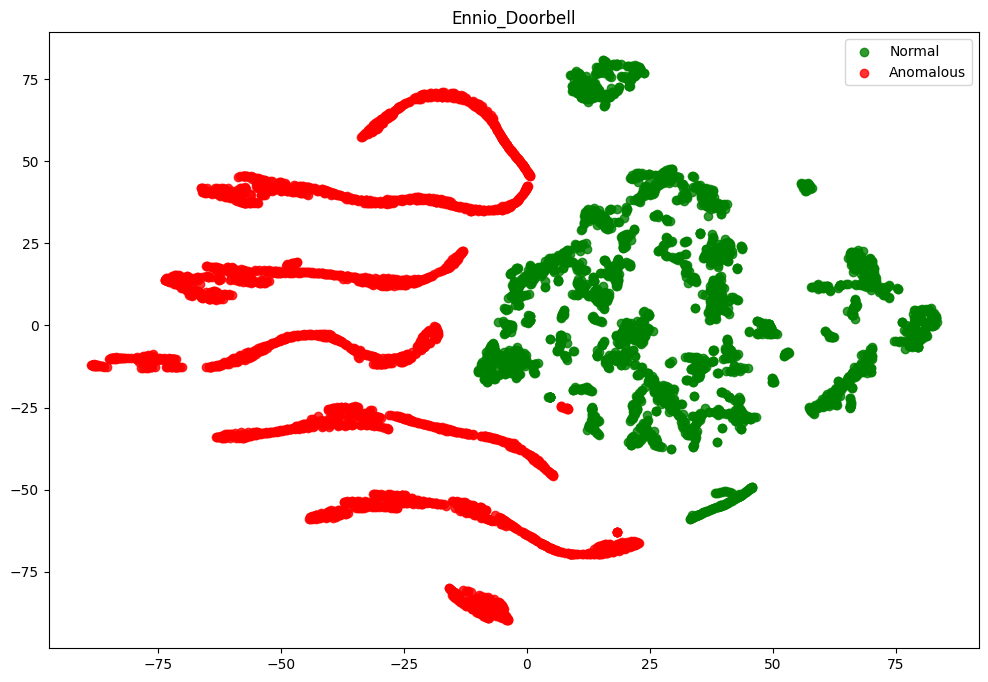

Ennio_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       739
         1.0       1.00      1.00      1.00       761

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


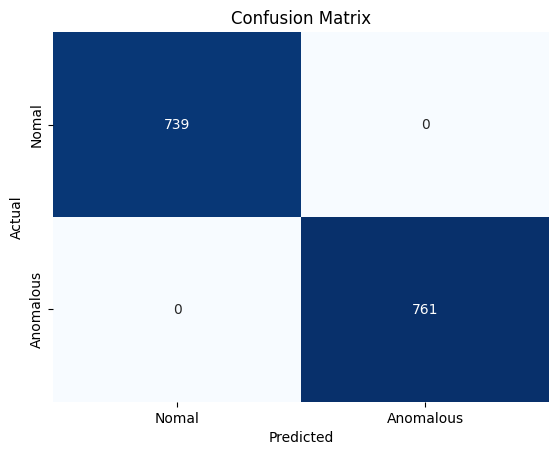

Epoch 1/10
4/4 [==============================] - 4s 197ms/step - loss: 0.2875 - val_loss: 0.1592
Epoch 2/10
4/4 [==============================] - 0s 46ms/step - loss: 0.2874 - val_loss: 0.1592
Epoch 3/10
4/4 [==============================] - 0s 50ms/step - loss: 0.2872 - val_loss: 0.1592
Epoch 4/10
4/4 [==============================] - 0s 50ms/step - loss: 0.2871 - val_loss: 0.1592
Epoch 5/10
4/4 [==============================] - 0s 53ms/step - loss: 0.2870 - val_loss: 0.1592
Epoch 6/10
4/4 [==============================] - 0s 49ms/step - loss: 0.2869 - val_loss: 0.1591
Epoch 7/10
4/4 [==============================] - 0s 40ms/step - loss: 0.2868 - val_loss: 0.1591
Epoch 8/10
4/4 [==============================] - 0s 51ms/step - loss: 0.2866 - val_loss: 0.1591
Epoch 9/10
4/4 [==============================] - 0s 49ms/step - loss: 0.2865 - val_loss: 0.1591
Epoch 10/10
94/94 [==============================] - 1s 5ms/step


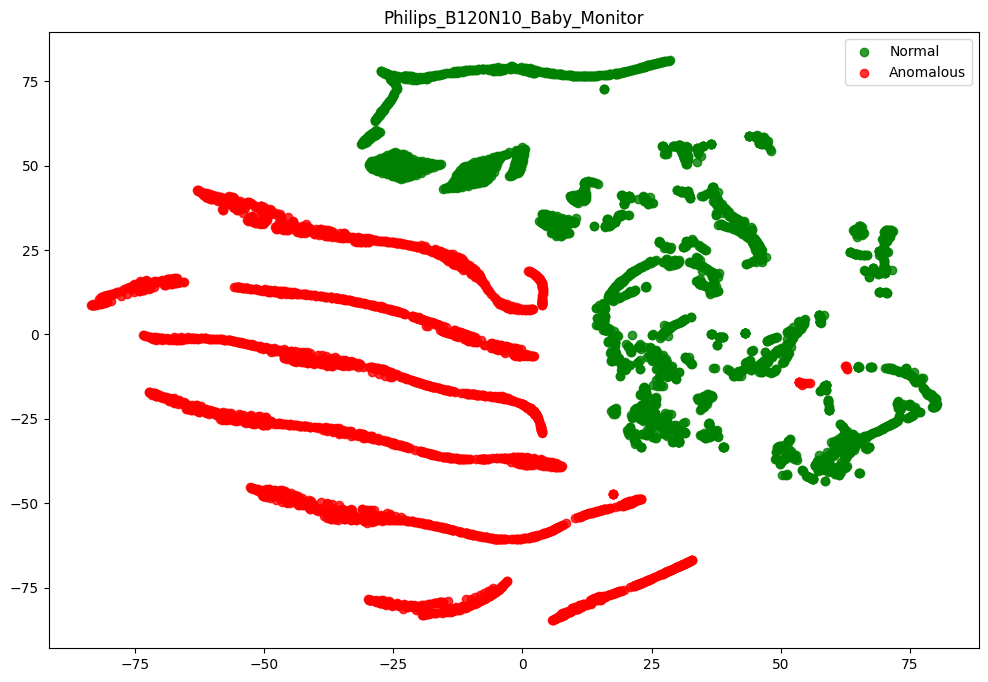

Philips_B120N10_Baby_Monitor

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       731
         1.0       1.00      1.00      1.00       769

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9986666666666667


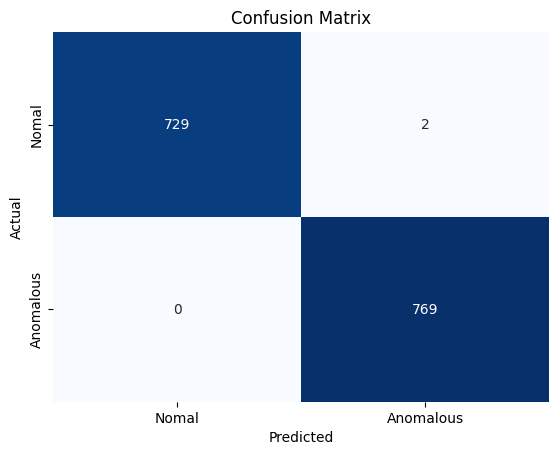

Epoch 1/10
4/4 [==============================] - 4s 205ms/step - loss: 0.0645 - val_loss: 0.0321
Epoch 2/10
4/4 [==============================] - 0s 50ms/step - loss: 0.0645 - val_loss: 0.0321
Epoch 3/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0645 - val_loss: 0.0321
Epoch 4/10
4/4 [==============================] - 0s 53ms/step - loss: 0.0645 - val_loss: 0.0321
Epoch 5/10
4/4 [==============================] - 0s 43ms/step - loss: 0.0645 - val_loss: 0.0320
Epoch 6/10
4/4 [==============================] - 0s 53ms/step - loss: 0.0645 - val_loss: 0.0320
Epoch 7/10
4/4 [==============================] - 0s 56ms/step - loss: 0.0644 - val_loss: 0.0320
Epoch 8/10
4/4 [==============================] - 0s 51ms/step - loss: 0.0644 - val_loss: 0.0320
Epoch 9/10
4/4 [==============================] - 0s 47ms/step - loss: 0.0644 - val_loss: 0.0320
Epoch 10/10
94/94 [==============================] - 1s 5ms/step


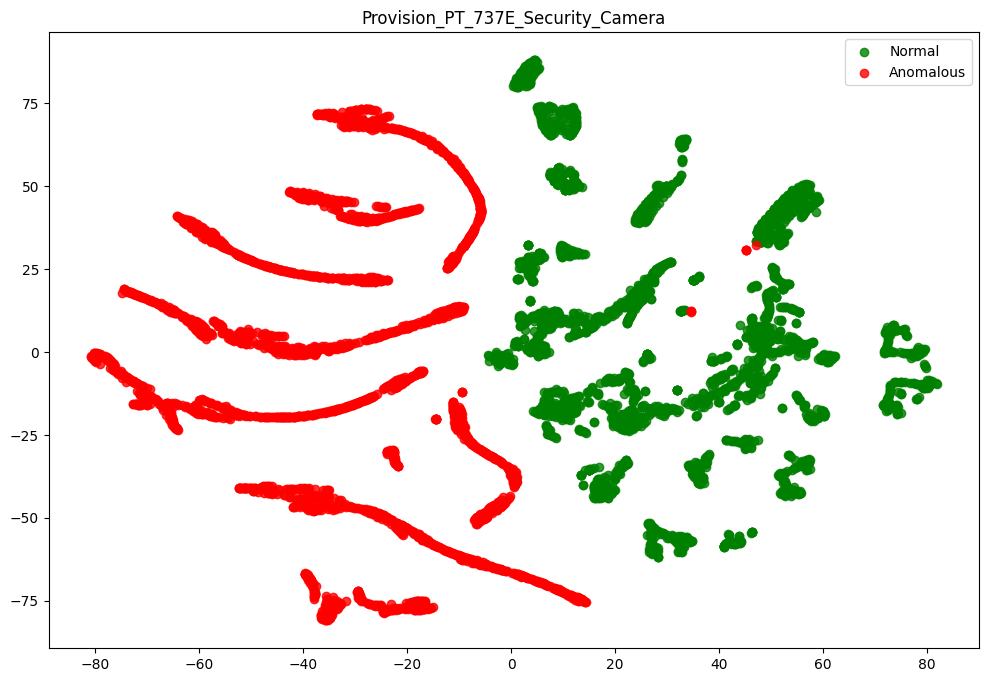

Provision_PT_737E_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       746
         1.0       1.00      1.00      1.00       754

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


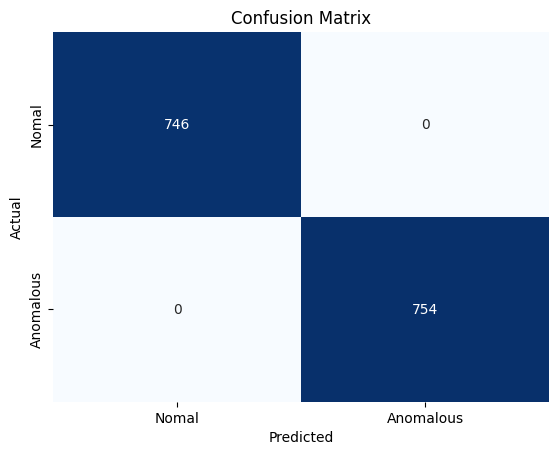

Epoch 1/10
4/4 [==============================] - 17s 900ms/step - loss: 0.0617 - val_loss: 0.0626
Epoch 2/10
4/4 [==============================] - 1s 200ms/step - loss: 0.0617 - val_loss: 0.0626
Epoch 3/10
4/4 [==============================] - 1s 232ms/step - loss: 0.0617 - val_loss: 0.0626
Epoch 4/10
4/4 [==============================] - 1s 231ms/step - loss: 0.0616 - val_loss: 0.0626
Epoch 5/10
4/4 [==============================] - 1s 208ms/step - loss: 0.0616 - val_loss: 0.0626
Epoch 6/10
4/4 [==============================] - 1s 203ms/step - loss: 0.0616 - val_loss: 0.0626
Epoch 7/10
4/4 [==============================] - 1s 198ms/step - loss: 0.0616 - val_loss: 0.0625
Epoch 8/10
4/4 [==============================] - 1s 197ms/step - loss: 0.0616 - val_loss: 0.0625
Epoch 9/10
4/4 [==============================] - 1s 195ms/step - loss: 0.0616 - val_loss: 0.0625
Epoch 10/10
94/94 [==============================] - 3s 25ms/step


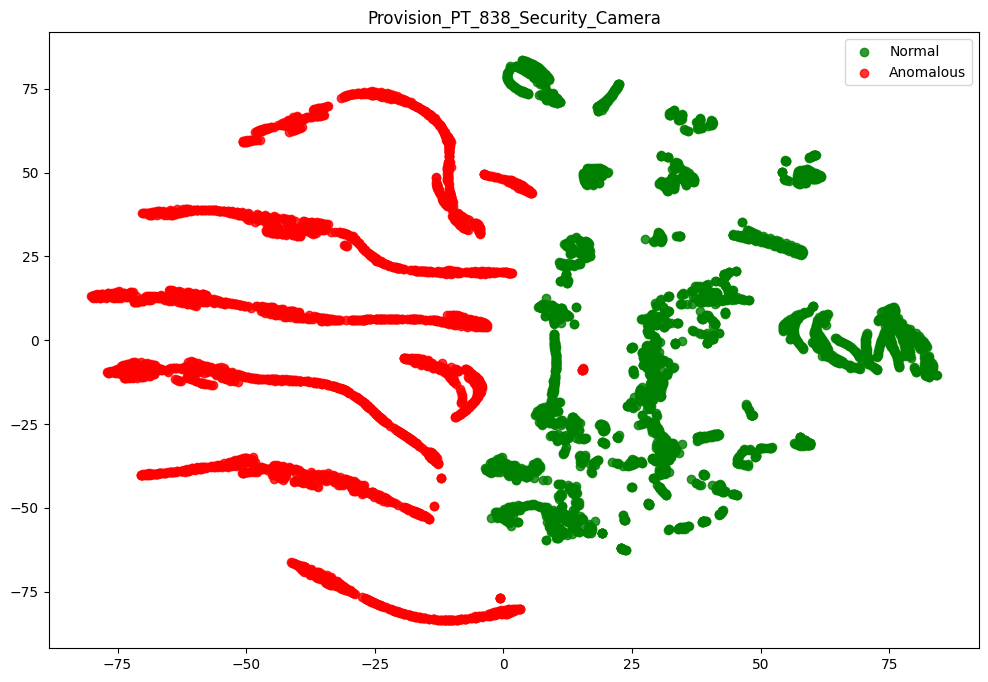

Provision_PT_838_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       744
         1.0       1.00      1.00      1.00       756

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


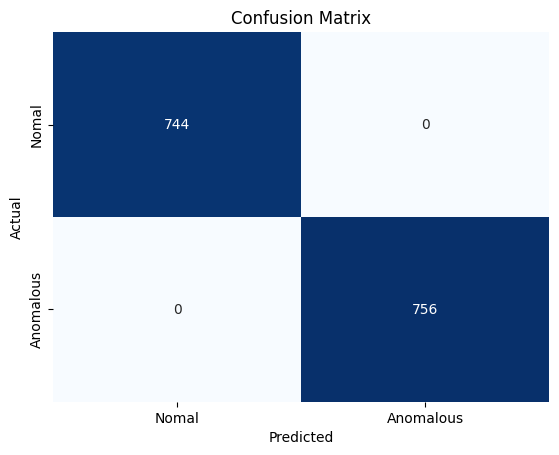

Epoch 1/10
4/4 [==============================] - 3s 168ms/step - loss: 0.0726 - val_loss: 0.0692
Epoch 2/10
4/4 [==============================] - 0s 32ms/step - loss: 0.0726 - val_loss: 0.0692
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0726 - val_loss: 0.0692
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.0725 - val_loss: 0.0691
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 0.0725 - val_loss: 0.0691
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 0.0725 - val_loss: 0.0691
Epoch 7/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0725 - val_loss: 0.0691
Epoch 8/10
4/4 [==============================] - 0s 39ms/step - loss: 0.0725 - val_loss: 0.0690
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0724 - val_loss: 0.0690
Epoch 10/10
94/94 [==============================] - 0s 4ms/step


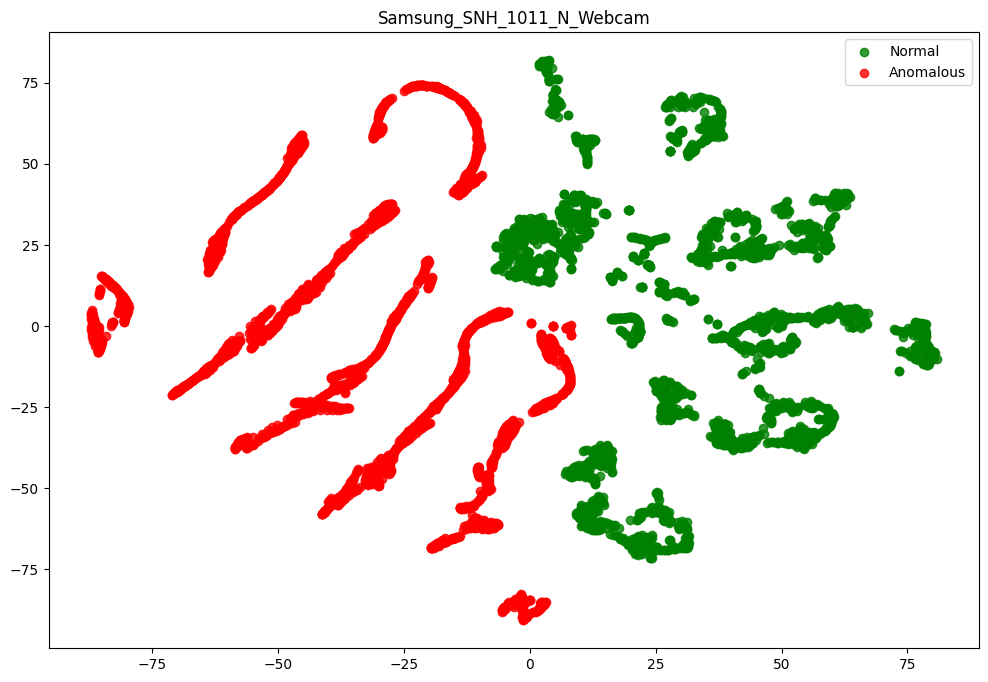

Samsung_SNH_1011_N_Webcam

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       745
         1.0       1.00      1.00      1.00       755

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9993333333333333


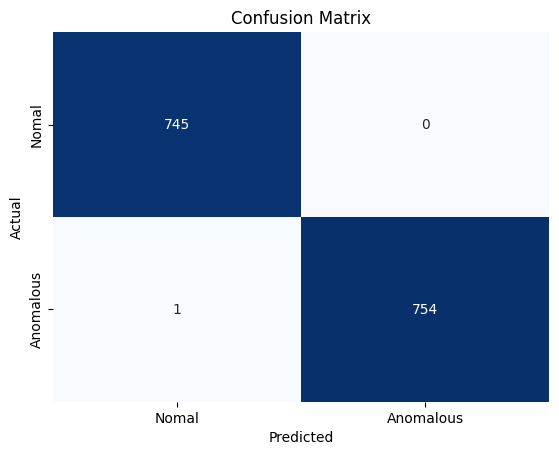

Epoch 1/10
4/4 [==============================] - 3s 181ms/step - loss: 0.0915 - val_loss: 0.1005
Epoch 2/10
4/4 [==============================] - 0s 48ms/step - loss: 0.0915 - val_loss: 0.1005
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 0.0915 - val_loss: 0.1005
Epoch 4/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0914 - val_loss: 0.1004
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 0.0914 - val_loss: 0.1004
Epoch 6/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0914 - val_loss: 0.1004
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0914 - val_loss: 0.1004
Epoch 8/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0914 - val_loss: 0.1003
Epoch 9/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0913 - val_loss: 0.1003
Epoch 10/10
94/94 [==============================] - 0s 3ms/step


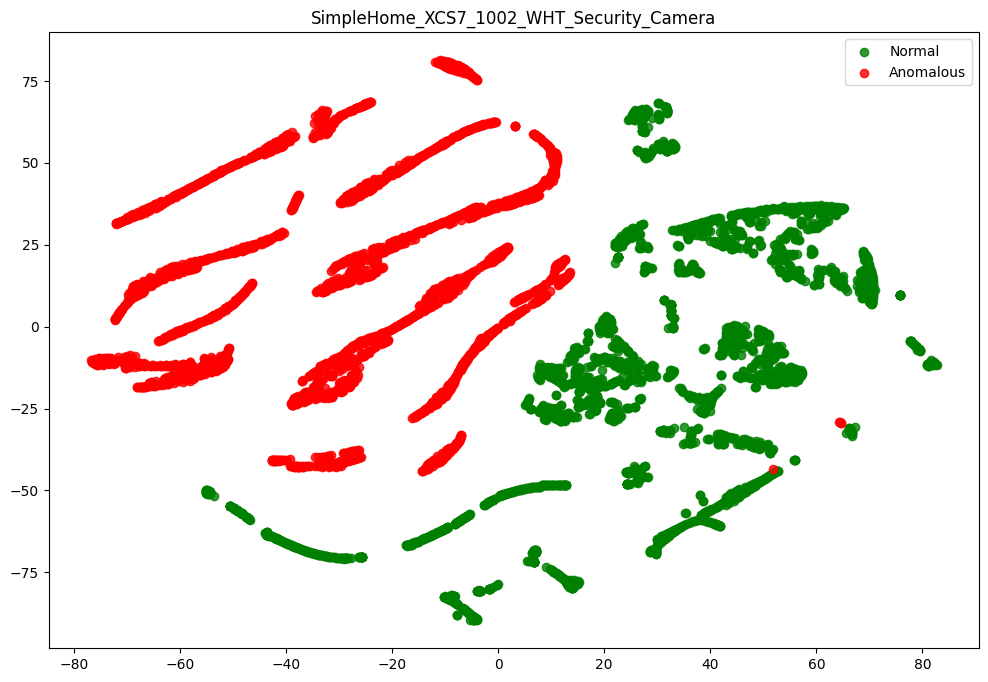

SimpleHome_XCS7_1002_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       763
         1.0       1.00      1.00      1.00       737

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9993333333333333


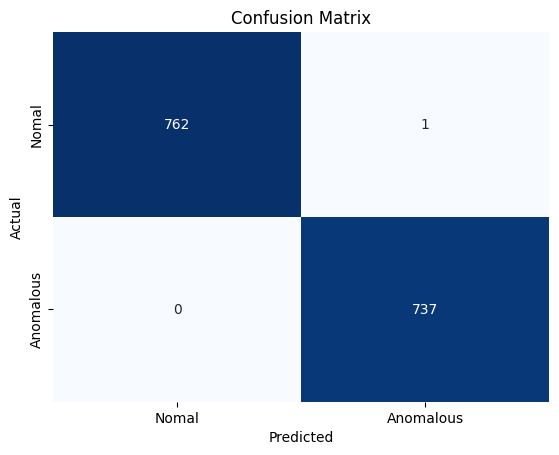

Epoch 1/10
4/4 [==============================] - 3s 198ms/step - loss: 0.0846 - val_loss: 0.0699
Epoch 2/10
4/4 [==============================] - 0s 44ms/step - loss: 0.0846 - val_loss: 0.0699
Epoch 3/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0846 - val_loss: 0.0699
Epoch 4/10
4/4 [==============================] - 0s 43ms/step - loss: 0.0846 - val_loss: 0.0698
Epoch 5/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0845 - val_loss: 0.0698
Epoch 6/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0845 - val_loss: 0.0698
Epoch 7/10
4/4 [==============================] - 0s 43ms/step - loss: 0.0845 - val_loss: 0.0698
Epoch 8/10
4/4 [==============================] - 0s 45ms/step - loss: 0.0845 - val_loss: 0.0697
Epoch 9/10
4/4 [==============================] - 0s 42ms/step - loss: 0.0845 - val_loss: 0.0697
Epoch 10/10
94/94 [==============================] - 0s 4ms/step


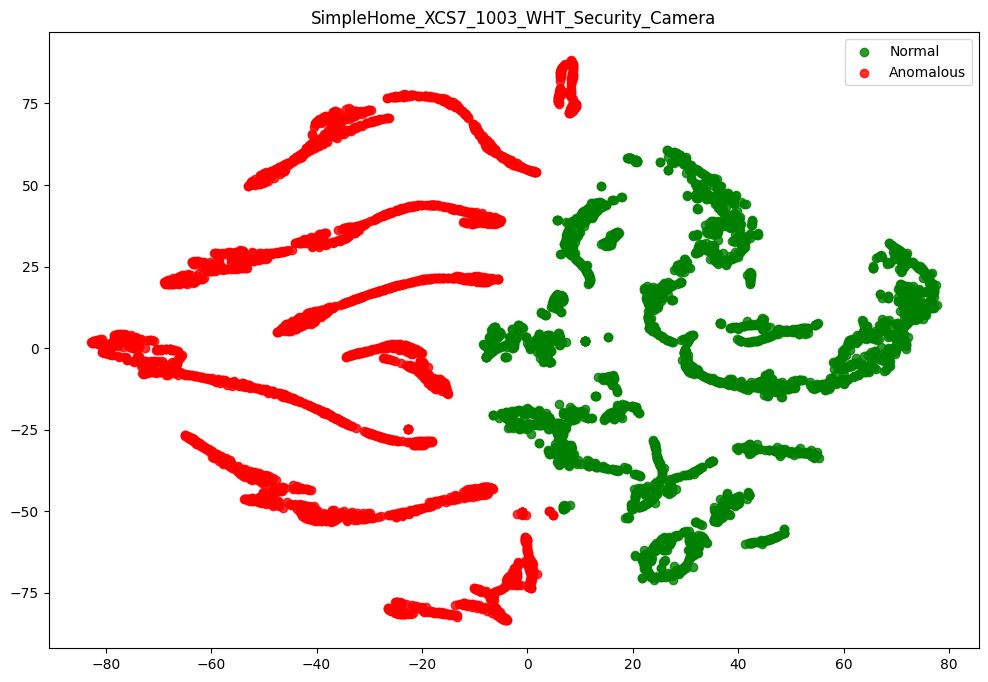

SimpleHome_XCS7_1003_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       737
         1.0       1.00      1.00      1.00       763

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


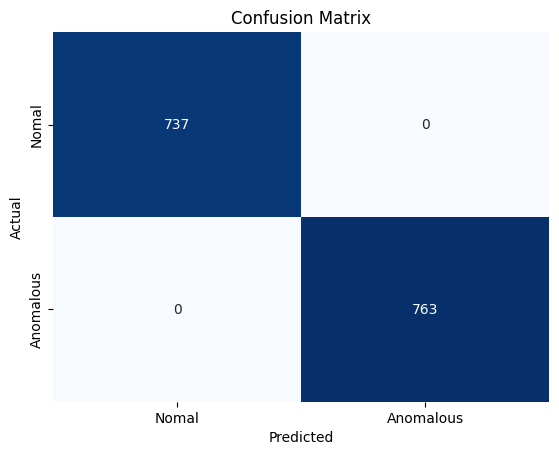

In [15]:
devices = ['Danmini_Doorbell', # Chuông cửa thông minh
           'Ecobee_Thermostat', # Thiết bị điều khiển nhiệt thông minh
           'Ennio_Doorbell', # Chuông cửa thông minh
           'Philips_B120N10_Baby_Monitor', # Thiết bị giám sát trẻ thông minh
           'Provision_PT_737E_Security_Camera', # 1 loại camera an ninh
           'Provision_PT_838_Security_Camera', # 1 loại camera an ninh
           'Samsung_SNH_1011_N_Webcam', #Webcam của samsung 
           'SimpleHome_XCS7_1002_WHT_Security_Camera', # Camera an ninh của simplehome
           'SimpleHome_XCS7_1003_WHT_Security_Camera'] # Camera an ninh của simplehome
#devices = ['Danmini_Doorbell', 'Ecobee_Thermostat']
for device_id, device_name in enumerate(devices, 1):
    detect_zero_day_attack(device_name, device_id)
    # Mỗi vòng lặp hàm detect gọi lại với 2 đối số d_name và d_id